In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
#import math
#from sklearn.preprocessing import OneHotEncoder
from scipy.stats import zscore

# Feature Selection Imports
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor

# Regression Imports
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Keras RNN packages
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

plt.rcParams['figure.figsize'] = [32, 25] # width, height

Using TensorFlow backend.


# What models will I make?
I plan to explore two possible models: Regression model and RNN  

For the regression model, I will simply predict the most recent death count to predict.  

For the RNN, I will use the full death times series.  

I will use different feature selection methods to find the most important features for predicting death counts. 

Read cleaned dataset

In [2]:
df_covid_raw = pd.read_csv("data/df_covid.csv")
df_covid_raw.head()

,FIPS,County,State,POP_ESTIMATE_2018,R_NATURAL_INC_2018,R_NET_MIG_2018,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,...,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20
0,1001,Autauga,Alabama,55601,2.2,0.6,11.3,32.6,28.4,27.7,...,2,3,4,4,4,3,3,3,3,3
1,1003,Baldwin,Alabama,218022,0.1,24.8,9.7,27.6,31.3,31.3,...,3,3,3,3,3,4,4,4,4,5
2,1005,Barbour,Alabama,24881,-2.5,-8.6,27.0,35.7,25.1,12.2,...,0,0,0,1,1,1,1,1,1,1
3,1013,Butler,Alabama,19680,-0.9,-10.1,15.4,43.9,24.6,16.1,...,1,1,1,1,1,1,1,1,1,2
4,1015,Calhoun,Alabama,114277,-1.8,-1.6,15.9,32.4,33.7,18.0,...,3,3,3,3,3,3,3,3,3,3


# Feature Selection  

In [3]:
# 1/22/20 is the first date in df_covid --> get column number of first date in df_covid
first_date_col = df_covid_raw.columns.get_loc("1/22/20")

 ### First, I will use a univariate approach and remove parameters that are highly correlated

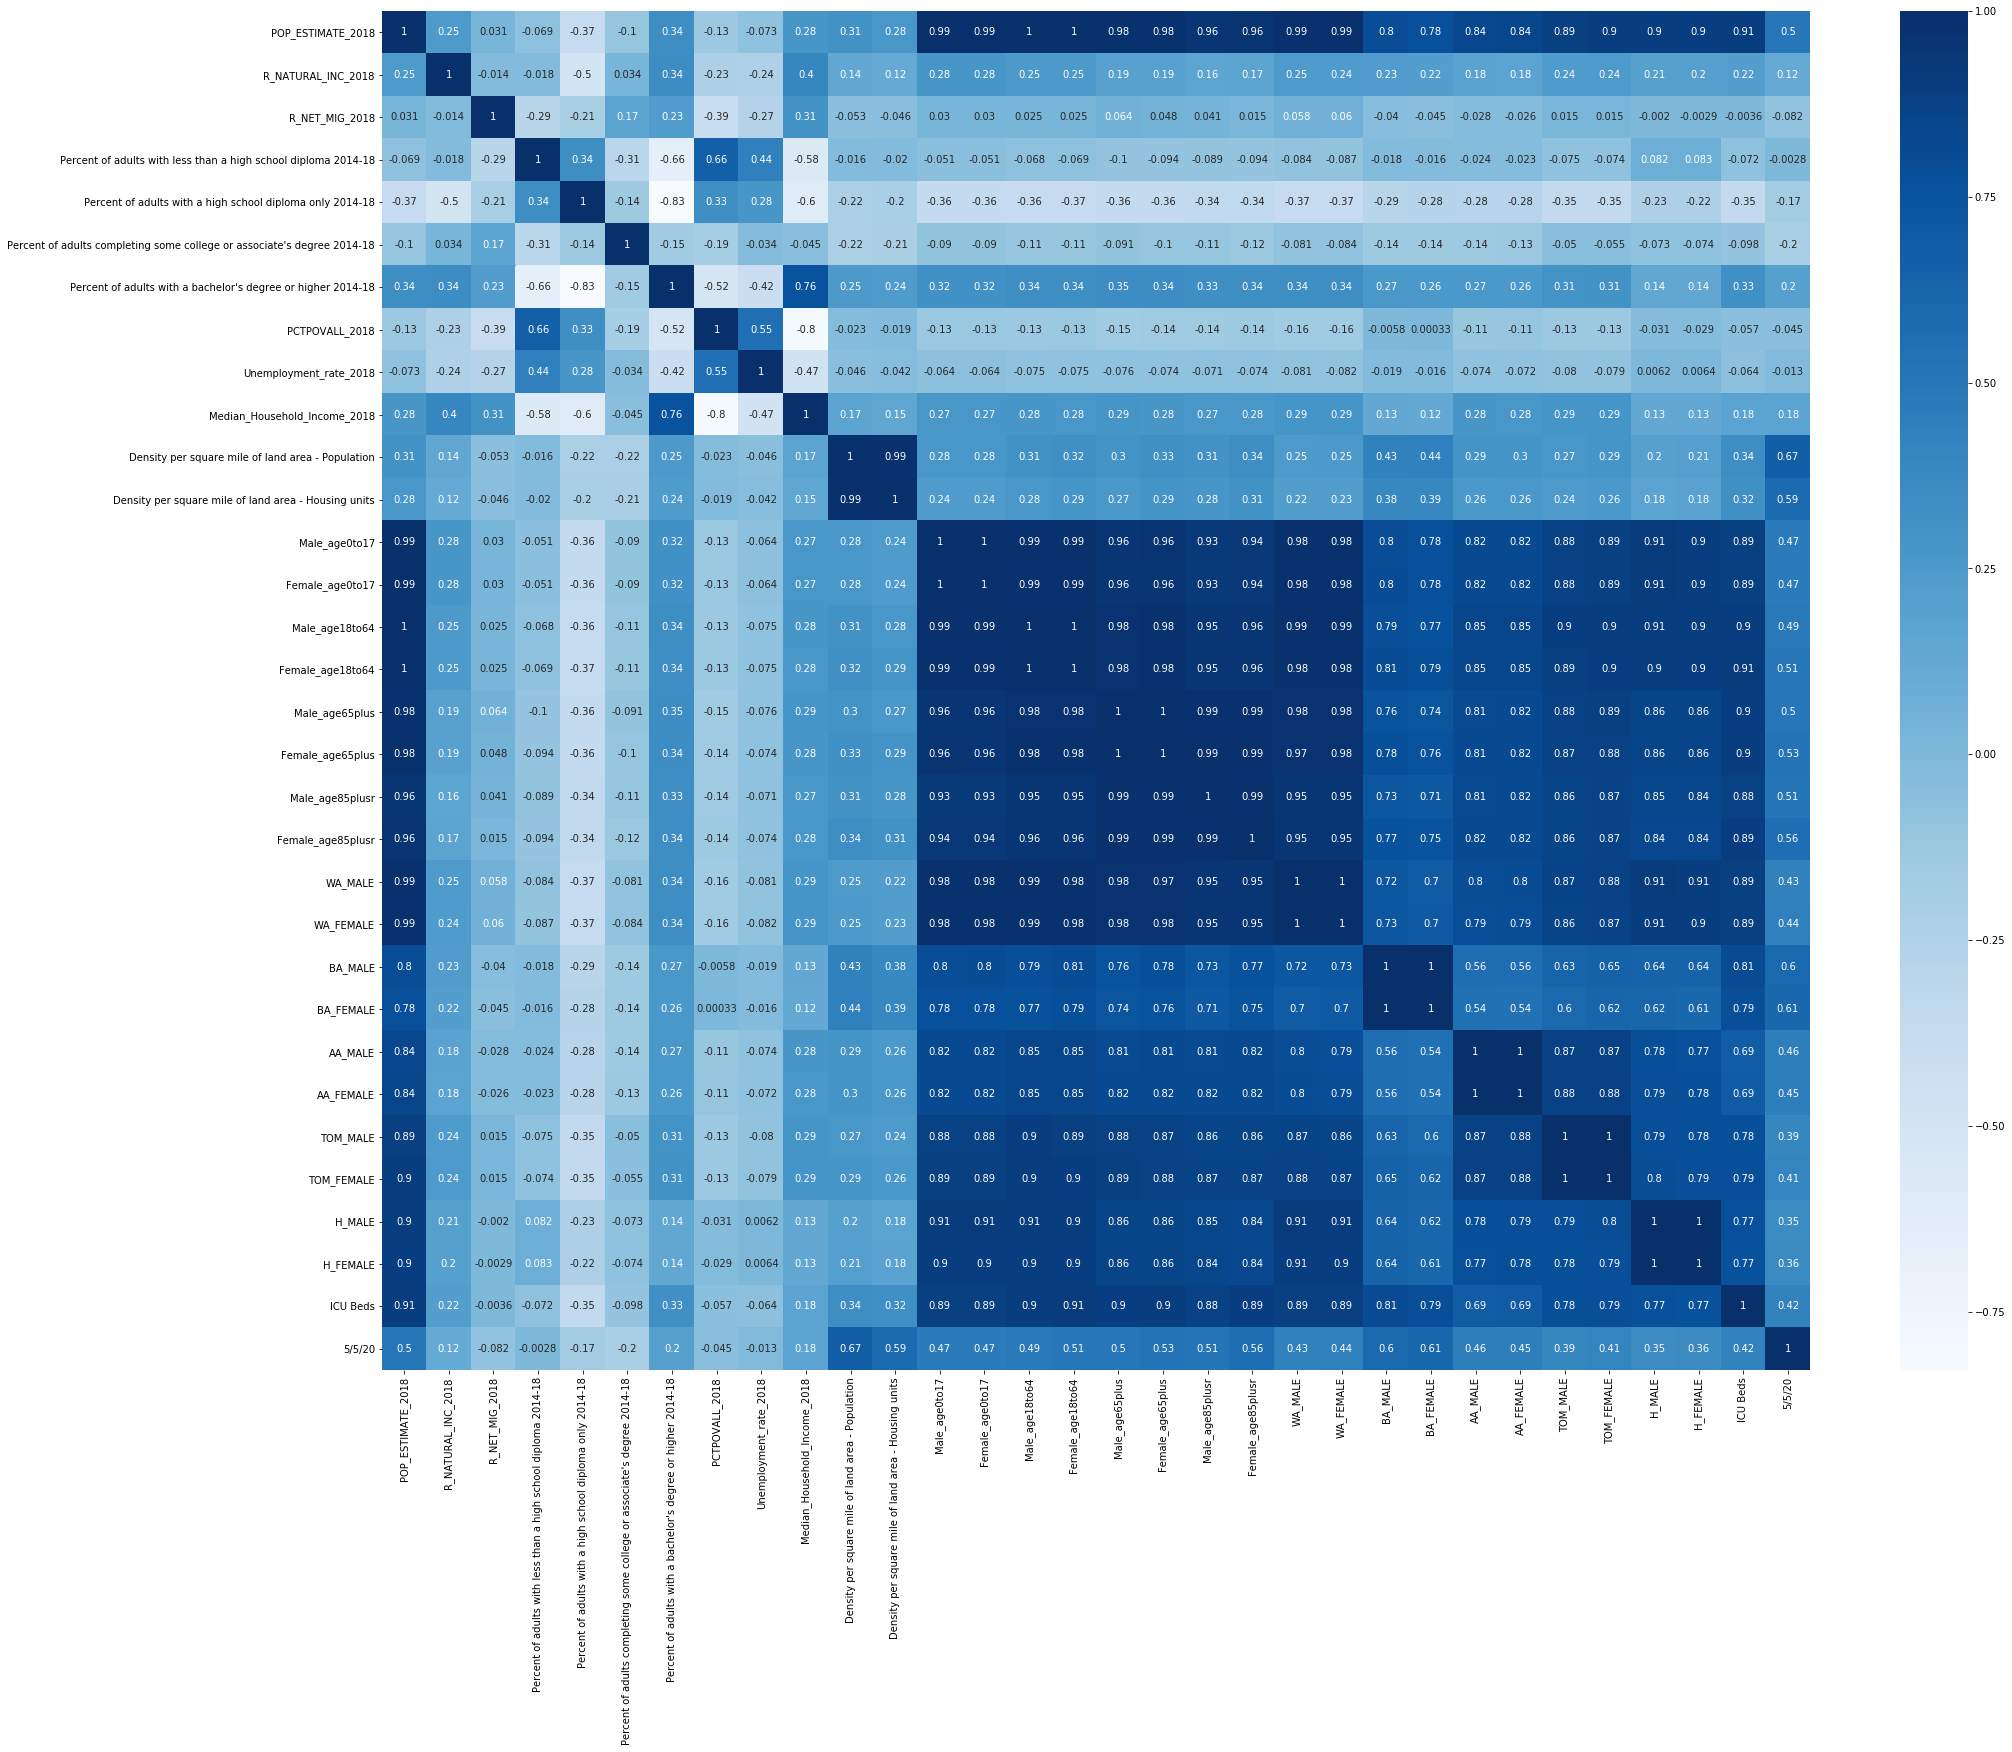

In [4]:
sns.heatmap(df_covid_raw.iloc[:,list(range(3,first_date_col)) + [-1]].corr(), cmap="Blues", annot=True)
plt.show()

From the above heatmap I notice the following:  

1) "Density per square mile of land area - Population" and "Density per square mile of land area - Housing Units" are strongly correlated. I will remove the housing units density since population density is more correlated with the death count of our most recent date.

2) Also, the population estimate equals the sum of the male and femal age ranges. For regressions, I do not want an independent variable to be a function of the other independent variables. Also, population density seems more important from a heuristic view, so I will drop POP_ESTIMATE_2018 as well.  

3) "Median household income" is strongly correlated with "percent of adults with a bachelors degree or higher". However, I do not want to drop one of these features yet since they are two different stats. I will let the more advanced multivariate approaches decide if one of these features should be dropped.

4) There is a 'square' of mostly strong correlations between the age ranges and the ethnicity data. As I mentioned in 3), these stats are different so I would like to see what the multivariate approaches think

5) ICU beds is highly correlated to population estimate and the age ranges and ethnicity data. I will keep this stat for now because I think it is a cool stat and I am already dropping population estimate. It is not as strongly correlated to population density which is interesting as well.





In [5]:
df_covid = df_covid_raw.drop(["POP_ESTIMATE_2018", "Density per square mile of land area - Housing units"], axis=1)
first_date_col -= 2 # update the column number of 1/22/20

### Select k-best

In [7]:
fs = SelectKBest(score_func=f_regression, k=10)
selected_vars = fs.fit(df_covid.iloc[:,list(range(3,first_date_col))], df_covid.iloc[:,-1])
display(df_covid.iloc[:,list(range(3,first_date_col))].columns[selected_vars.get_support()])

Index(['Density per square mile of land area - Population', 'Male_age0to17',
       'Male_age18to64', 'Female_age18to64', 'Male_age65plus',
       'Female_age65plus', 'Male_age85plusr', 'Female_age85plusr', 'BA_MALE',
       'BA_FEMALE'],
      dtype='object')

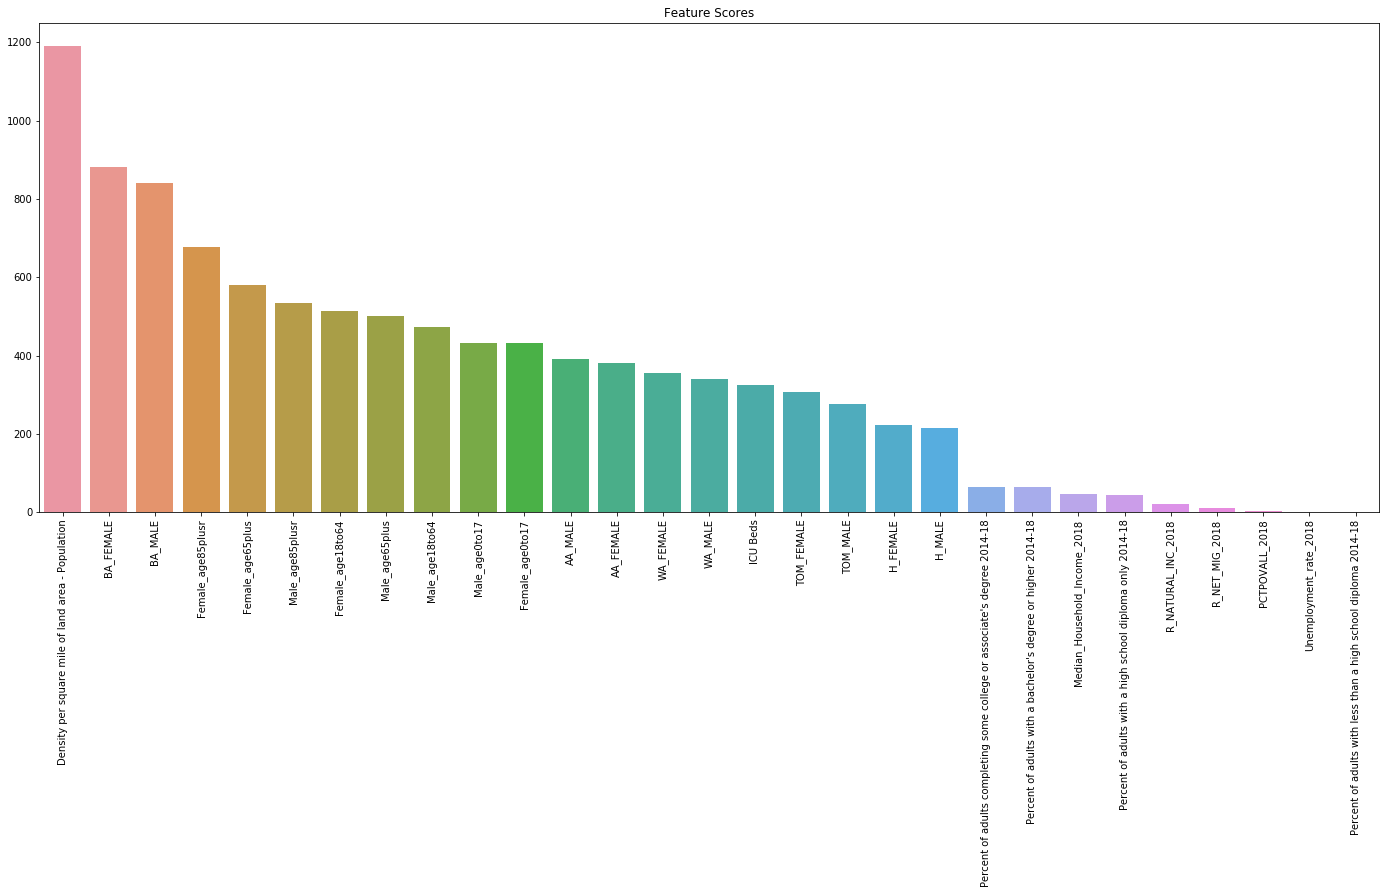

In [8]:
columns = df_covid.iloc[:,list(range(3,first_date_col))].columns

# define a dictionary where keys are column names and values are scores
col_val = dict(zip(columns, selected_vars.scores_))

# define a dictionary where keys are feature importances and values are column names
val_col = dict(zip(selected_vars.scores_, columns))

# Create descending lists of column names and correpsonding feature importances
sorted_cols = list()
for i in sorted(val_col.keys()):
    for key, value in col_val.items():
        if (value == i):
            sorted_cols.append(key)
            
sorted_cols = sorted_cols[::-1] # get descending order
sorted_vals = sorted(val_col.keys())[::-1] # get descending order

dict_kbest = dict(zip(sorted_cols,sorted_vals))

# Create plot
plt.rcParams['figure.figsize'] = [24, 9] # width, height
ax = sns.barplot(x=sorted_cols, y=sorted_vals)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Feature Scores")
plt.show()

## Now I will explore some multivariate approaches

### Forward Selection  
Ref: https://towardsdatascience.com/feature-selection-using-wrapper-methods-in-python-f0d352b346f

In [9]:
sfs_f = SFS(LinearRegression(), k_features=10, forward=True, scoring='r2', cv=0) # If i use cross validation, I get a negative r^2...
sfs_f.fit(df_covid.iloc[:,list(range(3,first_date_col))], df_covid.iloc[:,-1])

# get list of features added in order
f_ordered_features = []
for i in range(1,11):
    for feature in sfs_f.subsets_[i]["feature_names"]:
        if (feature not in f_ordered_features):
            f_ordered_features.append(feature)
            continue
f_ordered_features

['Density per square mile of land area - Population',
 'Female_age85plusr',
 'Male_age85plusr',
 'ICU Beds',
 'BA_FEMALE',
 'BA_MALE',
 "Percent of adults with a bachelor's degree or higher 2014-18",
 'H_MALE',
 'Male_age0to17',
 'Female_age0to17']

C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


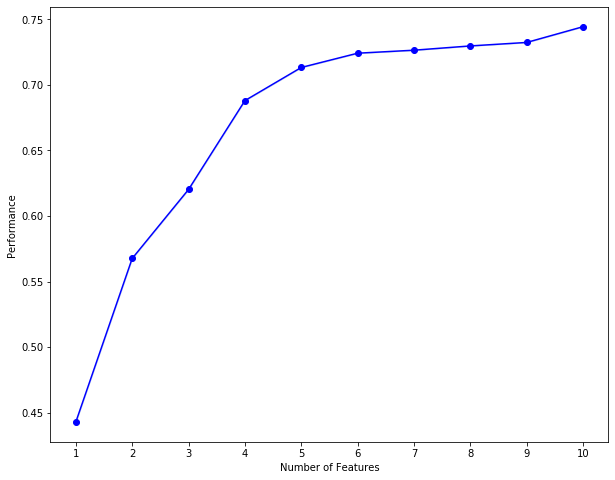

In [10]:
plt.rcParams['figure.figsize'] = [10, 8] # width, height
plot_sfs(sfs_f.get_metric_dict(), kind='std_dev')
plt.show()

#### Backward Elimination

In [11]:
# Setting forward=False is the only difference, in terms of parameters, between forward selection & backward elimination
sfs_b = SFS(LinearRegression(), k_features=1, forward=False, scoring='r2', cv=0) # k_features=1 since I want to get the order of the last 10 removed features
sfs_b.fit(df_covid.iloc[:,list(range(3,first_date_col))], df_covid.iloc[:,-1])

# get list of features added in order
b_ordered_features = []
for i in range(1,11):
    for feature in sfs_b.subsets_[i]["feature_names"]:
        if (feature not in b_ordered_features):
            b_ordered_features.append(feature)
            continue
b_ordered_features

['Density per square mile of land area - Population',
 'Female_age85plusr',
 'Male_age85plusr',
 'ICU Beds',
 'WA_MALE',
 'Male_age0to17',
 'TOM_MALE',
 'Female_age0to17',
 'Male_age65plus',
 'Female_age18to64']

C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\ahawk\Anaconda3\envs\csci349\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


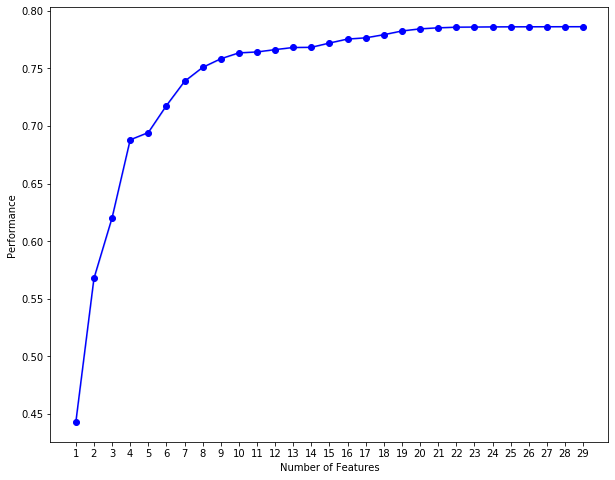

In [12]:
plt.rcParams['figure.figsize'] = [10, 8] # width, height
plot_sfs(sfs_b.get_metric_dict(), kind='std_dev')
plt.show()

#### Random Forest  
Ref: https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f  

train data is the county socioeconomic variables  
my test data is the most recent death count for a county  

In [13]:
# split into train and test data
x_train,x_test,y_train,y_test = train_test_split(df_covid.iloc[:,list(range(3,first_date_col))], df_covid.iloc[:,-1], test_size=0.3)

feature_select = SelectFromModel(RandomForestRegressor(n_estimators=1000, verbose=1))
feature_select.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   35.9s finished


SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                                criterion='mse', max_depth=None,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                max_samples=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=1000, n_jobs=None,
                                                oob_score=False,
                                                random_state=None, verbose=1,
                                                wa

### Plot the feature importances below

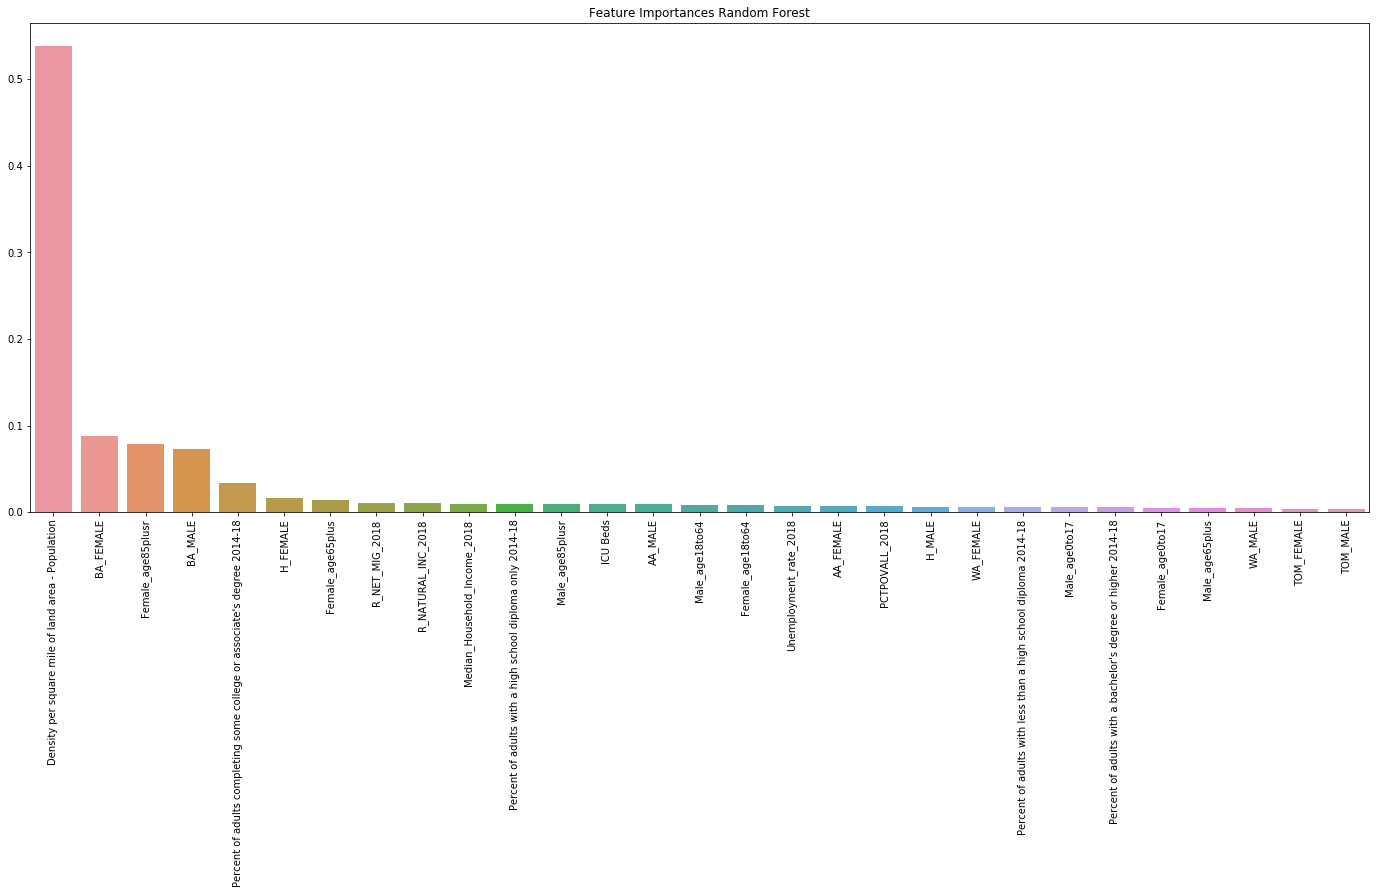

In [14]:
# define a dictionary where keys are column names and values are corresponding feature importances
col_val = dict(zip(df_covid.iloc[:,list(range(3,first_date_col))].columns, feature_select.estimator_.feature_importances_))

# define a dictionary where keys are feature importances and values are column names
val_col = dict(zip(feature_select.estimator_.feature_importances_, df_covid.iloc[:,list(range(3,first_date_col))].columns))

# Create descending lists of column names and correpsonding feature importances
sorted_cols = list()
for i in sorted(val_col.keys()):
    for key, value in col_val.items():
        if (value == i):
            sorted_cols.append(key)
            
sorted_cols = sorted_cols[::-1] # get descending order
sorted_vals = sorted(val_col.keys())[::-1] # get descending order

dict_trees = dict(zip(sorted_cols,sorted_vals))

# Create plot
plt.rcParams['figure.figsize'] = [24, 9] # width, height
ax = sns.barplot(x=sorted_cols, y=sorted_vals)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Feature Importances Random Forest")
plt.show()

#### Now I will use k-fold to find the feature importances

In [15]:
splits=10
kfold = KFold(n_splits = splits, shuffle=True, random_state=123)

column_names = df_covid.iloc[:,list(range(3,first_date_col))].columns

# Initialize a dictionary of feature values with zeros --> this will be updated with the features values generated during each fold
dict_feature_values = dict(zip(column_names, np.zeros(first_date_col-2)))

for train, test in kfold.split(df_covid):
    print("Starting Fold")
    feature_select = SelectFromModel(RandomForestRegressor(n_estimators=1000, verbose=1, n_jobs=3))
    feature_select.fit(df_covid.iloc[train,list(range(3,first_date_col))], df_covid.iloc[train,-1])
    # update the total feature values
    dict_update_values = dict(zip(column_names, feature_select.estimator_.feature_importances_))
    for key in dict_feature_values.keys():
        dict_feature_values[key] += dict_update_values[key]
        
# get the average feature value
for key in dict_feature_values.keys():
    dict_feature_values[key] /= splits

Starting Fold


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.9s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   18.0s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   22.6s finished


Starting Fold


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.2s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.7s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   17.8s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   22.6s finished


Starting Fold


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.1s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.7s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   17.8s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   22.5s finished


Starting Fold


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.4s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   18.5s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   23.3s finished


Starting Fold


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.8s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   17.7s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   22.3s finished


Starting Fold


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.2s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.1s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   18.4s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   23.1s finished


Starting Fold


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:    9.9s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   17.9s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   22.7s finished


Starting Fold


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.4s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   18.5s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   23.3s finished


Starting Fold


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.4s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.2s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   18.2s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   22.9s finished


Starting Fold


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   10.4s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:   19.1s
[Parallel(n_jobs=3)]: Done 1000 out of 1000 | elapsed:   23.8s finished


#### Plot the results of the k-fold feature selector

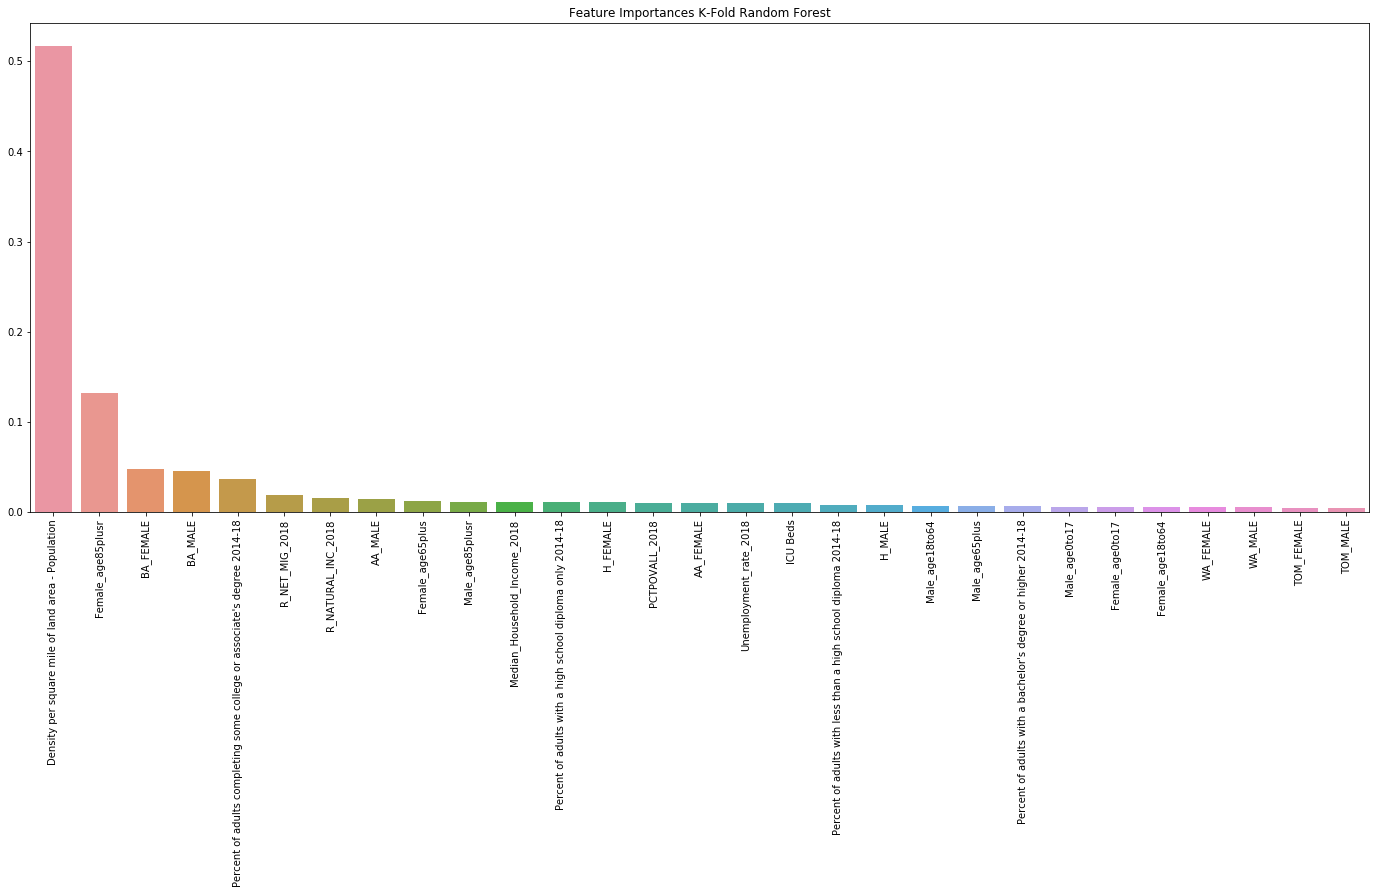

In [16]:

# define a dictionary where keys are feature importances and values are column names
val_col = dict(zip(dict_feature_values.values(), dict_feature_values.keys()))

# Create descending lists of column names and correpsonding feature importances
sorted_cols = list()
for i in sorted(val_col.keys()):
    for key, value in dict_feature_values.items():
        if (value == i):
            sorted_cols.append(key)
            
sorted_cols = sorted_cols[::-1] # get descending order
sorted_vals = sorted(val_col.keys())[::-1] # get descending order

dict_trees_kfold = dict(zip(sorted_cols,sorted_vals))

# Create plot
plt.rcParams['figure.figsize'] = [24, 9] # width, height
ax = sns.barplot(x=sorted_cols, y=sorted_vals)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Feature Importances K-Fold Random Forest")
plt.show()

#### Plot the sum of the feature_importance.  
The top 6 features explain ~80% of the target variable and ~15 features explain ~90% of the target variable. From these results, I feel comfortable choosing 10 features for the RNN model.

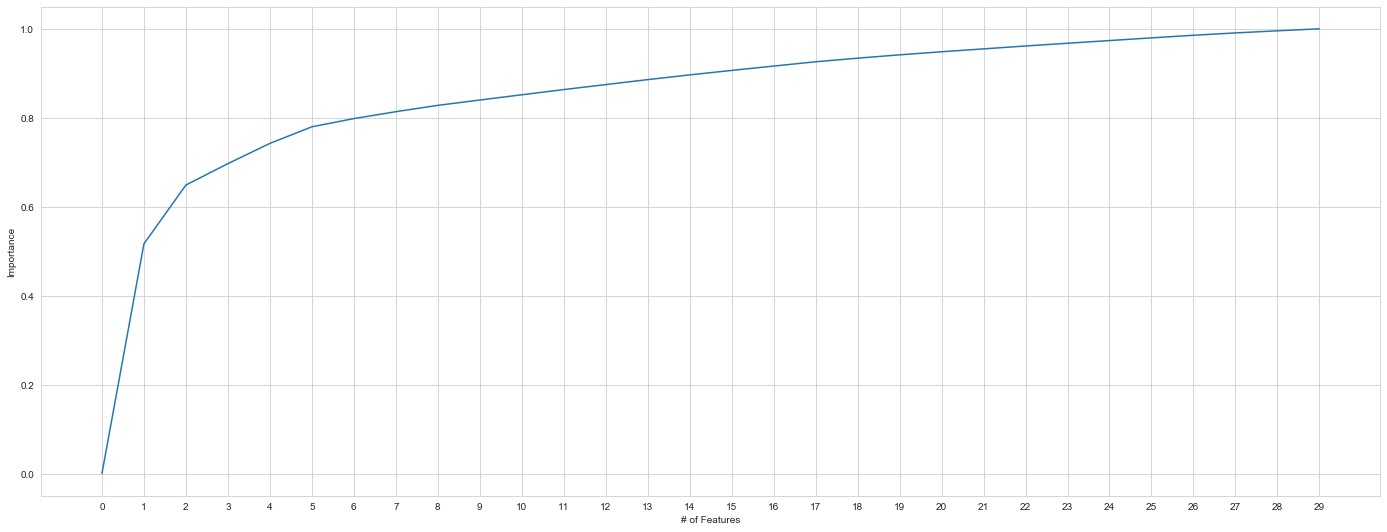

In [17]:
sum_of_importance = [0]
for value in dict_trees_kfold.values():
    sum_of_importance.append(sum_of_importance[-1]+value)
sns.set_style("whitegrid")
plt.xticks(list(range(len(dict_trees_kfold)+1)))
sns.lineplot(x=list(range(len(dict_trees_kfold)+1)), y=sum_of_importance)
plt.xlabel("# of Features")
plt.ylabel("Importance")
plt.show()

#### Below I compare the results of the above feature selections

In [18]:
pd.DataFrame({"k_best":list(dict_kbest.keys())[:10], "forward":f_ordered_features, "backward":b_ordered_features, "Random Forest":list(dict_trees.keys())[:10], "K-Fold Random Forest":list(dict_trees_kfold.keys())[:10]})

,k_best,forward,backward,Random Forest,K-Fold Random Forest
0,Density per square mile of land area - Population,Density per square mile of land area - Population,Density per square mile of land area - Population,Density per square mile of land area - Population,Density per square mile of land area - Population
1,BA_FEMALE,Female_age85plusr,Female_age85plusr,BA_FEMALE,Female_age85plusr
2,BA_MALE,Male_age85plusr,Male_age85plusr,Female_age85plusr,BA_FEMALE
3,Female_age85plusr,ICU Beds,ICU Beds,BA_MALE,BA_MALE
4,Female_age65plus,BA_FEMALE,WA_MALE,Percent of adults completing some college or a...,Percent of adults completing some college or a...
5,Male_age85plusr,BA_MALE,Male_age0to17,H_FEMALE,R_NET_MIG_2018
6,Female_age18to64,Percent of adults with a bachelor's degree or ...,TOM_MALE,Female_age65plus,R_NATURAL_INC_2018
7,Male_age65plus,H_MALE,Female_age0to17,R_NET_MIG_2018,AA_MALE
8,Male_age18to64,Male_age0to17,Male_age65plus,R_NATURAL_INC_2018,Female_age65plus
9,Male_age0to17,Female_age0to17,Female_age18to64,Median_Household_Income_2018,Male_age85plusr


From these results, I choose the top 10 features to include in the RNN model. Since 6 features sum to 80% of the importance for k-fold random forest, the next 4 features I choose can be features I am interested in. Explanations for why I chose some of the variables are below:

1) **"Density per square mile of land area - Population"** - it is the top feature for all selection methods  
2) **"ICU Beds"** - I included this variable since it is #4 for both forward and backward. It is also a cool variable.  
3) **R_NET_MIG_2018** - I trust the resuls of teh K-Fold Random Forest the most since it seems to be the most robust feature selector. Also, net migration realtes to people moving in and out of a county, which potentially is correlated to the spread of the virus.  
4) **Male_age0to17** - this is the variable I am most unsure of, but it appears in the top-10 for k_best, forward and backward, so I'll give it a chance. Also, I have a hunch that middle schoolers and high schoolers are more likely to wander around now and potentially spread the virus since they are not in school anymore.


In [6]:
best_features = ["Density per square mile of land area - Population", "Female_age85plusr", "Male_age85plusr", "BA_FEMALE", "BA_MALE", "R_NET_MIG_2018", 
                 "Percent of adults completing some college or associate's degree 2014-18", "Male_age0to17", "Median_Household_Income_2018", "ICU Beds"]
len(best_features)

10

## RNN Modeling  

First we will drop all unwanted features

Well, after some research, I found the following links very useful:  
1) https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/  
2) https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/  
3) https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944  
4) https://lilianweng.github.io/lil-log/2017/07/22/predict-stock-prices-using-RNN-part-2.html  


The fourth link is the most similar to my problem (LSTM with multiple stocks instead of 1). Unfortunately, I do not think I will be able to create an RNN in time.  

The other three links cover how to create an RNN that predicts a target value (stock price) for one class (company).  

An RNN is difficult enough to build, but building an RNN to handle multiple counties seems extremely difficult. I didn't realize the level of difficulty until it came time to model.  

Instead, I will focus on regression models. The regression models will attempt to predict the most recent day's covid death count for each county.

## Regression

I will show the R^2, MAE, and RMSE of OLS regression, Ridge regression, and Lasso regression below on three sets of features:    
1) Regression without feature selection  
2) Regression with the best features  
3) Regression with the top 5 features of the random forest feature selection &#8594; "Density per square mile of land area - Population", "Female_age85plusr", "BA_FEMALE", "BA_MALE", "Percent of adults completing some college or associate's degree 2014-18"  

I also try the OLS regression on the third and fourth quartile.  
I then try a support vector regression.  
Lastly, I attempt a OLS regression using the death time series. This model ends up being the best by far.

#### Apply standardization to the variables instead of normalization since the dataset has some features with negative values e.g. R_NET_MIG_2018

In [20]:
first_date_col = df_covid.columns.get_loc("1/22/20")
df_covid_norm = df_covid.copy()
df_covid_norm.iloc[:,3:first_date_col] = df_covid_norm.iloc[:,3:first_date_col].apply(zscore)

#### Define function to cleanly print R^2, MAE, RMSE for both training and testing data

In [21]:
def get_metrics(results):
    print("R^2 train: {:.3f}".format(results["train_r2"].mean()))
    print("MAE train: {:.3f}".format(-1*results["train_neg_mean_absolute_error"].mean()))
    print("RMSE train {:.3f}".format(-1*results["train_neg_root_mean_squared_error"].mean()))
    print("R^2 test: {:.3f}".format(results["test_r2"].mean()))
    print("MAE test: {:.3f}".format(-1*results["test_neg_mean_absolute_error"].mean()))
    print("RMSE test: {:.3f}".format(-1*results["test_neg_root_mean_squared_error"].mean()))

### OLS Regression  

Since OLS Regression is invariant, it is not necessary to use the normalize the data. If I were to use normalized data, I would get the same result. So, in the below cells, I use df_covid instead of df_covid_norm.

#### Define Model and K_Fold Parameters

In [22]:
kfold = KFold(n_splits=10, shuffle=True, random_state=321)
model = LinearRegression()
scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']

#### OLS Regression without feature selection

In [23]:
first_date_col = df_covid.columns.get_loc("1/22/20")
get_metrics(cross_validate(model, df_covid.iloc[:,list(range(3, first_date_col))], df_covid.iloc[:,-1], cv=kfold, scoring=scoring, return_train_score=True))

R^2 train: 0.788
MAE train: 48.144
RMSE train 103.280
R^2 test: 0.158
MAE test: 54.130
RMSE test: 130.090


#### OLS Regression with best features

In [24]:
first_date_col = df_covid.columns.get_loc("1/22/20")
keep_cols = list(df_covid.iloc[:,:3]) + best_features + list(df_covid.iloc[:,first_date_col:].columns)
df_covid_best = df_covid.loc[:,keep_cols]

first_date_col = df_covid_best.columns.get_loc("1/22/20")
get_metrics(cross_validate(model, df_covid_best.iloc[:,list(range(3, first_date_col))], df_covid_best.iloc[:,-1], cv=kfold, scoring=scoring, return_train_score=True))

R^2 train: 0.725
MAE train: 45.747
RMSE train 117.972
R^2 test: 0.225
MAE test: 47.494
RMSE test: 126.275


#### OLS Regression with top-5 random forest features

In [25]:
# Get dataset with top-5 features of k-fold random forest
first_date_col = df_covid.columns.get_loc("1/22/20")
keep_cols = list(df_covid.iloc[:,:3]) + ["Density per square mile of land area - Population", "Female_age85plusr", "BA_FEMALE", "BA_MALE", 
                                         "Percent of adults completing some college or associate's degree 2014-18"] + list(df_covid.iloc[:,first_date_col:].columns)
df_covid_5 = df_covid.loc[:,keep_cols]

first_date_col = df_covid_5.columns.get_loc("1/22/20")
get_metrics(cross_validate(model, df_covid_5.iloc[:,list(range(3, first_date_col))], df_covid_best.iloc[:,-1], cv=kfold, scoring=scoring, return_train_score=True))

R^2 train: 0.631
MAE train: 45.086
RMSE train 136.888
R^2 test: 0.164
MAE test: 46.382
RMSE test: 137.981


### Interpreting the results
The R^2 result is biased towards the number of features. As we increase the number of features, the R^2 value will increase no matter what. With that said, the test R^2 values are pretty low.  
The test MAE is the lowest when using the top-5 random forest features.  
The test RMSE is the lowest when using the 10 best features. However, the RMSE is sensitive to outliers, and with less features there are more outliers. This outlier sensitivity explains why the test RMSE is higher for the top-5 random forest features.  



## Ridge Regression  
Since Ridge Regression is variant, I use df_covid_norm in the below cells.

#### Define Model and K_Fold Parameters

In [26]:
kfold = KFold(n_splits=10, shuffle=True, random_state=321)
model = Ridge(alpha=1)
scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']

#### Ridge Regression without feature selection

In [27]:
first_date_col = df_covid_norm.columns.get_loc("1/22/20")
get_metrics(cross_validate(model, df_covid_norm.iloc[:,list(range(3, first_date_col))], df_covid_norm.iloc[:,-1], cv=kfold, scoring=scoring, return_train_score=True))

R^2 train: 0.759
MAE train: 45.835
RMSE train 110.438
R^2 test: 0.152
MAE test: 50.108
RMSE test: 128.330


#### Ridge Regression with best features

In [28]:
first_date_col = df_covid_norm.columns.get_loc("1/22/20")
keep_cols = list(df_covid_norm.iloc[:,:3]) + best_features + list(df_covid_norm.iloc[:,first_date_col:].columns)
df_covid_best = df_covid_norm.loc[:,keep_cols]

first_date_col = df_covid_best.columns.get_loc("1/22/20")
get_metrics(cross_validate(model, df_covid_best.iloc[:,list(range(3, first_date_col))], df_covid_best.iloc[:,-1], cv=kfold, scoring=scoring, return_train_score=True))

R^2 train: 0.722
MAE train: 44.674
RMSE train 118.595
R^2 test: 0.229
MAE test: 46.237
RMSE test: 125.828


#### Ridge Regression with top-5 random forest features

In [29]:
# Get dataset with top-5 features of k-fold random forest
first_date_col = df_covid_norm.columns.get_loc("1/22/20")
keep_cols = list(df_covid_norm.iloc[:,:3]) + ["Density per square mile of land area - Population", "Female_age85plusr", "BA_FEMALE", "BA_MALE", 
                                         "Percent of adults completing some college or associate's degree 2014-18"] + list(df_covid_norm.iloc[:,first_date_col:].columns)
df_covid_5 = df_covid_norm.loc[:,keep_cols]

first_date_col = df_covid_5.columns.get_loc("1/22/20")
get_metrics(cross_validate(model, df_covid_5.iloc[:,list(range(3, first_date_col))], df_covid_best.iloc[:,-1], cv=kfold, scoring=scoring, return_train_score=True))

R^2 train: 0.623
MAE train: 43.474
RMSE train 138.327
R^2 test: 0.210
MAE test: 44.491
RMSE test: 136.514


### Interpreting the results  
The R^2 result is biased towards the number of features. As we increase the number of features, the R^2 value will increase no matter what. With the test R^2 scores are pretty low.   
The test MAE is the lowest when using the top-5 random forest features.  
The test RMSE is the lowest when using the 10 best features. However, the RMSE is sensitive to outliers, and with less features there are more outliers. This outlier sensitivity explains why the test RMSE is higher for the top-5 random forest features.  

Overall, the test results of the top-5 random forest features are all better for the Ridge regression than the OLS regression.

## Lasso Regression  
Since Lasso Regression is variant, I use df_covid_norm in the below cells.

#### Define Model and K_Fold Parameters

In [30]:
kfold = KFold(n_splits=10, shuffle=True, random_state=321)
model = Lasso(alpha=1, tol = 0.002) # I need to increase the tolerance or else I get a convergence warning
scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']

#### Lasso Regression without feature selection

In [31]:
first_date_col = df_covid_norm.columns.get_loc("1/22/20")
get_metrics(cross_validate(model, df_covid_norm.iloc[:,list(range(3, first_date_col))], df_covid_norm.iloc[:,-1], cv=kfold, scoring=scoring, return_train_score=True))

R^2 train: 0.730
MAE train: 45.159
RMSE train 116.928
R^2 test: 0.087
MAE test: 48.081
RMSE test: 128.642


#### Lasso Regression with best features

In [32]:
first_date_col = df_covid_norm.columns.get_loc("1/22/20")
keep_cols = list(df_covid_norm.iloc[:,:3]) + best_features + list(df_covid_norm.iloc[:,first_date_col:].columns)
df_covid_best = df_covid_norm.loc[:,keep_cols]

first_date_col = df_covid_best.columns.get_loc("1/22/20")
get_metrics(cross_validate(model, df_covid_best.iloc[:,list(range(3, first_date_col))], df_covid_best.iloc[:,-1], cv=kfold, scoring=scoring, return_train_score=True))

R^2 train: 0.707
MAE train: 44.138
RMSE train 121.694
R^2 test: 0.191
MAE test: 45.852
RMSE test: 128.227


#### Lasso Regression with top-5 random forest features

In [33]:
# Get dataset with top-5 features of k-fold random forest
first_date_col = df_covid_norm.columns.get_loc("1/22/20")
keep_cols = list(df_covid_norm.iloc[:,:3]) + ["Density per square mile of land area - Population", "Female_age85plusr", "BA_FEMALE", "BA_MALE", 
                                         "Percent of adults completing some college or associate's degree 2014-18"] + list(df_covid_norm.iloc[:,first_date_col:].columns)
df_covid_5 = df_covid_norm.loc[:,keep_cols]

first_date_col = df_covid_5.columns.get_loc("1/22/20")
get_metrics(cross_validate(model, df_covid_5.iloc[:,list(range(3, first_date_col))], df_covid_best.iloc[:,-1], cv=kfold, scoring=scoring, return_train_score=True))

R^2 train: 0.593
MAE train: 44.395
RMSE train 143.936
R^2 test: 0.214
MAE test: 45.410
RMSE test: 138.988


### Interpreting the results  
The R^2 result is biased towards the number of features. As we increase the number of features, the R^2 value will increase no matter what. With the test R^2 scores are pretty low.   
The test MAE is the lowest when using the top-5 random forest features.  
The test RMSE is the lowest when using the 10 best features. However, the RMSE is sensitive to outliers, and with less features there are more outliers. This outlier sensitivity explains why the test RMSE is higher for the top-5 random forest features.  

Overall, the results of the top-5 random forest features are all worse than the Lasso Regression. However, the R^2 and MAE are better for Lasso compared to OLS, and the RMSE is worse for Lasso compared to OLS. 

## Now I will try the regression using quantiles
The model is not performing as well as it can since the data is insanely skewed (Refer to the quartile plots in the EDA section). So, I will use evaluate linear regression models on the third and fourth qurtiles. 

In [34]:
quartiles = np.array_split(df_covid.iloc[:,-1].sort_values(), 4)
df_covid_q3 = df_covid.iloc[quartiles[2].index, :]
df_covid_q4 = df_covid.iloc[quartiles[3].index, :]

In [35]:
kfold = KFold(n_splits=10, shuffle=True, random_state=321)
model = Ridge(alpha=1)
scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']

### OLS Regression with best features

In [36]:
# Get dataset with best features from df_covid
first_date_col = df_covid_q3.columns.get_loc("1/22/20")
keep_cols = list(df_covid_q3.iloc[:,:3]) + best_features + list(df_covid_q3.iloc[:,first_date_col:].columns)
df_covid_q3_best = df_covid_q3.loc[:,keep_cols]

first_date_col = df_covid_q3_best.columns.get_loc("1/22/20")
get_metrics(cross_validate(model, df_covid_q3_best.iloc[:,list(range(3, first_date_col))], df_covid_q3_best.iloc[:,-1], cv=kfold, scoring=scoring, return_train_score=True))

R^2 train: 0.042
MAE train: 2.524
RMSE train 3.009
R^2 test: -0.024
MAE test: 2.598
RMSE test: 3.078


In [37]:
first_date_col = df_covid_q4.columns.get_loc("1/22/20")
keep_cols = list(df_covid_q4.iloc[:,:3]) + best_features + list(df_covid_q4.iloc[:,first_date_col:].columns)
df_covid_q4_best = df_covid_q4.loc[:,keep_cols]

first_date_col = df_covid_q4_best.columns.get_loc("1/22/20")
get_metrics(cross_validate(model, df_covid_q4_best.iloc[:,list(range(3, first_date_col))], df_covid_q4_best.iloc[:,-1], cv=kfold, scoring=scoring, return_train_score=True))

R^2 train: 0.738
MAE train: 121.770
RMSE train 219.776
R^2 test: -0.074
MAE test: 138.786
RMSE test: 278.745


### Interpretting the results

These results are not that great. The MAE and RMSE seem amazing for quartile 3, but this is because the variance of the data is so small. The R^2 values are terrible for both quartiles. Splitting up the data by quartiles is NOT a good way to model deaths.

## Support Vector Regression
Since SVR is variant, I use df_covid_norm in the below cells.

#### Define Model and K_Fold Parameters

In [38]:
kfold = KFold(n_splits=10, shuffle=True, random_state=321)
model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']

#### SVR without feature selection

In [39]:
first_date_col = df_covid_norm.columns.get_loc("1/22/20")
get_metrics(cross_validate(model, df_covid_norm.iloc[:,list(range(3, first_date_col))], df_covid_norm.iloc[:,-1], cv=kfold, scoring=scoring, return_train_score=True))

R^2 train: 0.209
MAE train: 26.490
RMSE train 201.092
R^2 test: 0.323
MAE test: 33.826
RMSE test: 167.376


#### SVR with best features

In [40]:
first_date_col = df_covid_norm.columns.get_loc("1/22/20")
keep_cols = list(df_covid_norm.iloc[:,:3]) + best_features + list(df_covid_norm.iloc[:,first_date_col:].columns)
df_covid_best = df_covid_norm.loc[:,keep_cols]

first_date_col = df_covid_best.columns.get_loc("1/22/20")
get_metrics(cross_validate(model, df_covid_best.iloc[:,list(range(3, first_date_col))], df_covid_best.iloc[:,-1], cv=kfold, scoring=scoring, return_train_score=True))

R^2 train: 0.230
MAE train: 29.274
RMSE train 198.392
R^2 test: 0.353
MAE test: 33.131
RMSE test: 163.514


#### SVR with top-5 random forest features

In [41]:
# Get dataset with top-5 features of k-fold random forest
first_date_col = df_covid_norm.columns.get_loc("1/22/20")
keep_cols = list(df_covid_norm.iloc[:,:3]) + ["Density per square mile of land area - Population", "Female_age85plusr", "BA_FEMALE", "BA_MALE", 
                                         "Percent of adults completing some college or associate's degree 2014-18"] + list(df_covid_norm.iloc[:,first_date_col:].columns)
df_covid_5 = df_covid_norm.loc[:,keep_cols]

first_date_col = df_covid_5.columns.get_loc("1/22/20")
get_metrics(cross_validate(model, df_covid_5.iloc[:,list(range(3, first_date_col))], df_covid_best.iloc[:,-1], cv=kfold, scoring=scoring, return_train_score=True))

R^2 train: 0.257
MAE train: 31.190
RMSE train 194.822
R^2 test: 0.351
MAE test: 33.292
RMSE test: 161.735


### Interpreting the Results  

These results are comparable to the three linear regressions. Also, the MAE of the SVRs are smaller than the three linear regressions. Overall, these are good models. 

## Time series regression using OLS  

In order to do the time series regression properly, I must reshape the dataframe. The new dataframe is called df_covid_5_concat. It is a melted version of df_covid using the 5 best features from the k-fold random forest feature selection. The dataframe is a melted version of df_covid. The observations of the dataframe are every date,county pair in df_covid. So, this dataframe is much larger. This new dataframe is needed because I keep track of total days since the start date. I also add in death counts from the past 4 days. 

In [26]:
# Get dataset with top-5 features of k-fold random forest
# start on 3/14 --> 56 total deaths
start_date_col = df_covid.columns.get_loc("3/14/20")
keep_cols = list(df_covid.iloc[:,:3]) + ["Density per square mile of land area - Population", "Female_age85plusr", "BA_FEMALE", "BA_MALE", 
                                         "Percent of adults completing some college or associate's degree 2014-18"] + list(df_covid.iloc[:,start_date_col:].columns)
df_covid_5 = df_covid.loc[:,keep_cols]

num_dates = df_covid_5.iloc[:,8:].shape[1]

df_dates_melt = df_covid_5.iloc[:,8:].melt().rename(columns={"variable": "Date", "value": "Deaths"})


df_covid_5_concat = pd.concat([df_covid_5.iloc[:,:8]]*num_dates, ignore_index=True)

df_covid_5_concat.shape

df_covid_5_concat = pd.concat([df_covid_5_concat, df_dates_melt], axis=1, sort=False)


num_counties = df_covid.shape[0]
days_since_start = list()
for i in range(num_dates):
    days_since_start.append(num_counties*[i])
days_since_start = np.asarray(days_since_start).flatten()
days_since_start.shape

df_covid_5_concat["Days_Since_Start"] = days_since_start

df_covid_5_concat = df_covid_5_concat.set_index("Date", drop=True)
df_covid_5_concat

death_list = list(df_covid_5_concat.Deaths)
df_covid_5_concat["Deaths-1"] = (list(np.zeros(num_counties)) + death_list[:(len(death_list)-num_counties)])
df_covid_5_concat["Deaths-2"] = (list(np.zeros(2*num_counties)) + death_list[:(len(death_list)-2*num_counties)])
df_covid_5_concat["Deaths-3"] = (list(np.zeros(3*num_counties)) + death_list[:(len(death_list)-3*num_counties)])
df_covid_5_concat["Deaths-4"] = (list(np.zeros(4*num_counties)) + death_list[:(len(death_list)-4*num_counties)])

df_covid_5_concat = df_covid_5_concat.reindex(columns = ["FIPS", "County", "State", "Density per square mile of land area - Population", "Female_age85plusr", "BA_FEMALE", "BA_MALE", 
                                         "Percent of adults completing some college or associate's degree 2014-18", "Days_Since_Start","Deaths-4", "Deaths-3", "Deaths-2", "Deaths-1", "Deaths"])

print(df_covid_5_concat.shape)
print(df_covid_5_concat.info())

(79394, 14)
<class 'pandas.core.frame.DataFrame'>
Index: 79394 entries, 3/14/20 to 5/5/20
Data columns (total 14 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   FIPS                                                                     79394 non-null  int64  
 1   County                                                                   79394 non-null  object 
 2   State                                                                    79394 non-null  object 
 3   Density per square mile of land area - Population                        79394 non-null  float64
 4   Female_age85plusr                                                        79394 non-null  int64  
 5   BA_FEMALE                                                                79394 non-null  int64  
 6   BA_MALE                                                 

#### Below we see that the sudo-death time-series looks good

In [27]:
df_covid_5_concat[df_covid_5_concat.County == "Queens"].iloc[[-1],:]

,FIPS,County,State,Density per square mile of land area - Population,Female_age85plusr,BA_FEMALE,BA_MALE,Percent of adults completing some college or associate's degree 2014-18,Days_Since_Start,Deaths-4,Deaths-3,Deaths-2,Deaths-1,Deaths
Date,,,,,,,,,,,,,,
5/5/20,36081,Queens,New York,20553.6,33287,255651,216256,22.4,52,3993.0,4035.0,4102.0,4149.0,4213


### Below, I will use the first 51 dates of data as my training data, and I will use the day 52 as my testing data.

In [28]:
x_train = df_covid_5_concat.iloc[:num_counties*52,3:-1]
y_train = df_covid_5_concat.iloc[:num_counties*52,-1]
x_test = df_covid_5_concat.iloc[num_counties*52:,3:-1]
y_test = df_covid_5_concat.iloc[num_counties*52:,-1]

reg = LinearRegression().fit(x_train, y_train)
predictions = reg.predict(x_test)
print("R^2: {}".format(reg.score(x_test,y_test)))
print("MAE: {}".format(mean_absolute_error(y_test, predictions)))
print("RMSE: {}".format(mean_squared_error(y_test, predictions, squared=False)))

R^2: 0.9996903510813531
MAE: 1.0916524816281155
RMSE: 3.9865802888434545


### Interpreting the Results
All of the metrics of this model are so much better than any of the previous ones. The inclusion of the 4 previous days of death counts certainly helped the model's performance a lot!

#### Below I observe how the predicted death counts compare to the actual death counts in New York

In [29]:
df_results = x_test
df_results["Actual Deaths"] = y_test
df_results["Predicted Deaths"] = predictions
df_results["FIPS"] = df_covid_5_concat.iloc[num_counties*52:,0]
df_results["County"] = df_covid_5_concat.iloc[num_counties*52:,1]
df_results["State"] = df_covid_5_concat.iloc[num_counties*52:,2]
df_results[df_results.State=="New York"].iloc[:,10:]

,Actual Deaths,Predicted Deaths,FIPS,County,State
Date,,,,,
5/5/20,49,51.516802,36001,Albany,New York
5/5/20,3046,3049.582625,36005,Bronx,New York
5/5/20,22,22.394759,36007,Broome,New York
5/5/20,1,0.920159,36011,Cayuga,New York
5/5/20,4,4.300468,36013,Chautauqua,New York
5/5/20,1,0.986126,36015,Chemung,New York
5/5/20,4,3.897987,36019,Clinton,New York
5/5/20,16,16.588786,36021,Columbia,New York
5/5/20,4,4.102750,36025,Delaware,New York


#### Heatmap

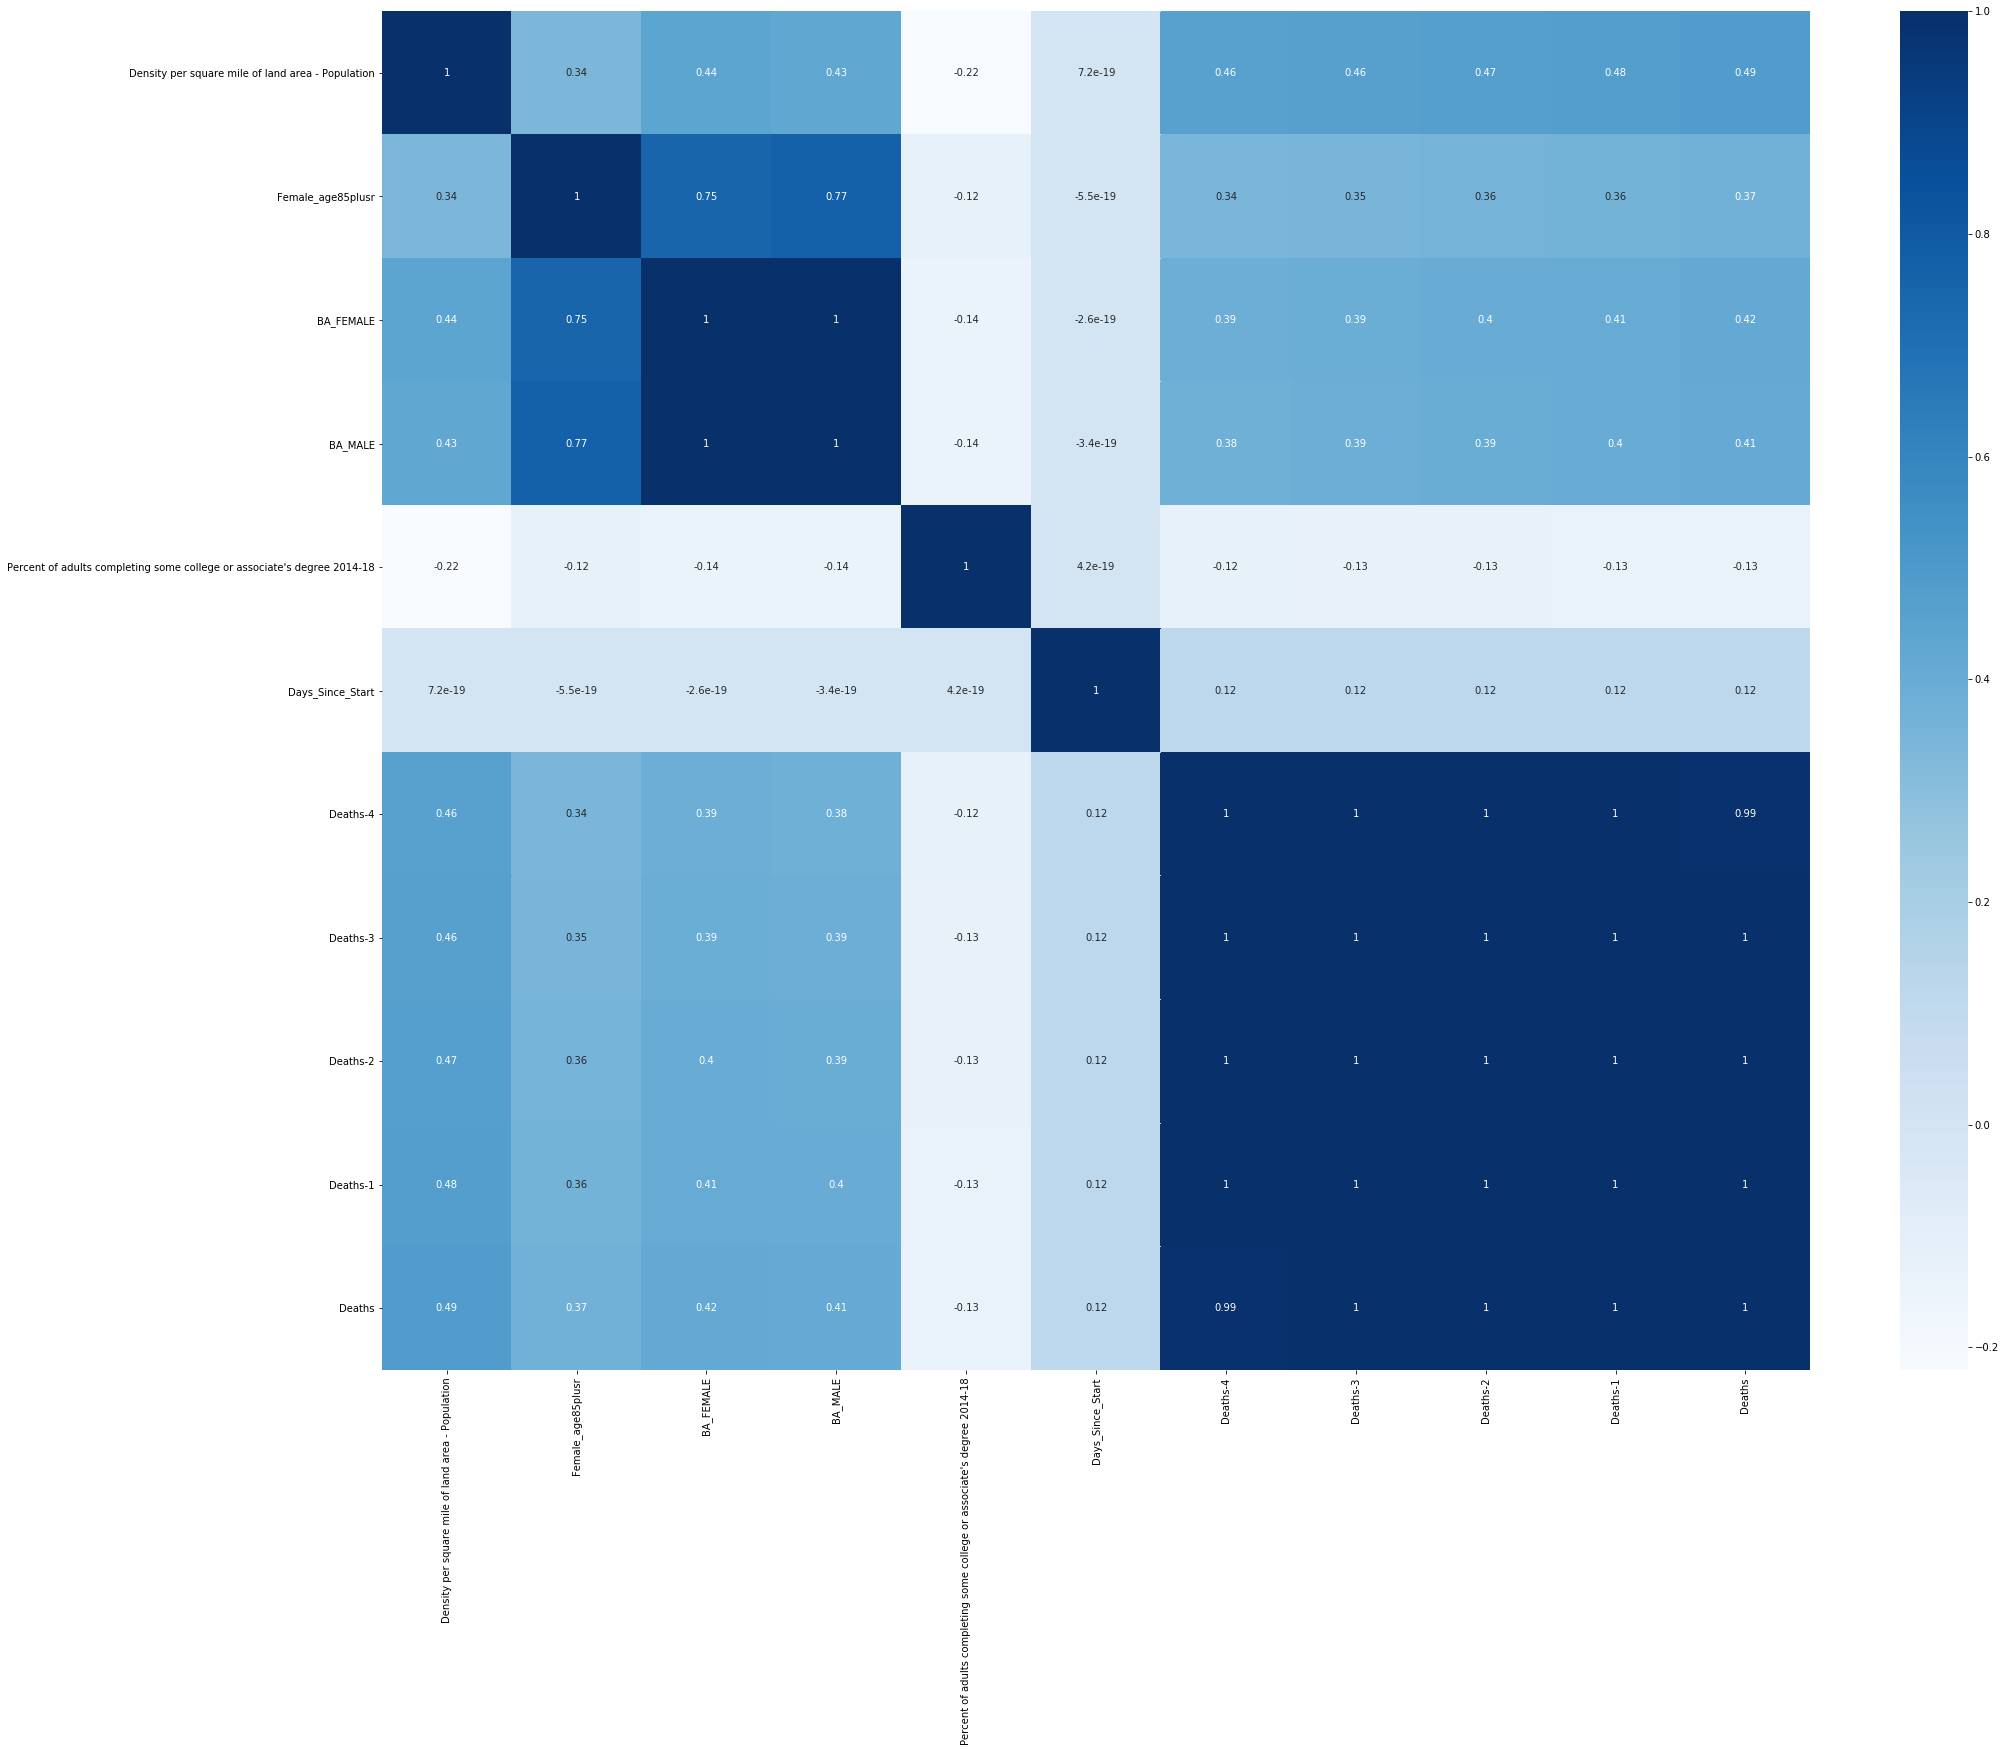

In [17]:
sns.heatmap(df_covid_5_concat.iloc[:,3:].corr(), cmap="Blues", annot=True)
plt.show()

In [35]:
len(reg.coef_)
len(df_covid_5_concat.iloc[:,3:-1].columns)

10

In [38]:
pd.DataFrame({"Coefficients": reg.coef_}, index = df_covid_5_concat.iloc[:,3:-1].columns).sort_values(by="Coefficients", ascending=False)

,Coefficients
Deaths-1,1.147606
Deaths-2,0.215502
Days_Since_Start,0.002228
Density per square mile of land area - Population,0.000165
BA_FEMALE,0.000100
Female_age85plusr,0.000073
BA_MALE,-0.000113
Percent of adults completing some college or associate's degree 2014-18,-0.009067
Deaths-3,-0.149939
Deaths-4,-0.208191
